In [1]:
from covidcast.covidcast import signal
import pandas as pd
import numpy as np
from etna.datasets import TSDataset
from etna.models import SeasonalMovingAverageModel, CatBoostPerSegmentModel, LinearPerSegmentModel
from etna.transforms import LagTransform, LinearTrendTransform, DateFlagsTransform
import matplotlib.pyplot as plt
from FACI.faci import conformalAdaptStable
from FACI.get_error import get_errors
from FACI.compute_beta import computeBetasByGeoByTime, computeConfInt
from FACI.analysis import plot_coverage_level, plot_with_intervals
from etna.analysis.utils import prepare_axes
import warnings
warnings.filterwarnings('ignore')

<h3> Create dataset </h3>

In [2]:
start_day = pd.Timestamp("2020-04-11")
end_day = pd.Timestamp("2022-05-01")

geo_values = signal("jhu-csse", "confirmed_cumulative_num",
                    pd.Timestamp("2020-05-14"), pd.Timestamp("2020-05-14"))["geo_value"].astype(int)
f = pd.read_csv("f.csv")
c = pd.read_csv("c.csv")
f = f[f["geo_value"].isin(geo_values)][["geo_value", "time_value", "value"]]
c = c[c["geo_value"].isin(geo_values)][["geo_value", "time_value", "value"]]
countiesToUse = [6075, 36061, 12086, 48113]
c = c[c["geo_value"].isin(countiesToUse)]
f = f[f["geo_value"].isin(countiesToUse)]

c.rename(columns={"geo_value": "segment", "time_value": "timestamp", "value": "target"}, inplace=True)
f.rename(columns={"geo_value": "segment", "time_value": "timestamp", "value": "facebook"}, inplace=True)

f = TSDataset.to_dataset(f)
c = TSDataset.to_dataset(c)
ts = TSDataset(df=c, freq="D", df_exog=f)

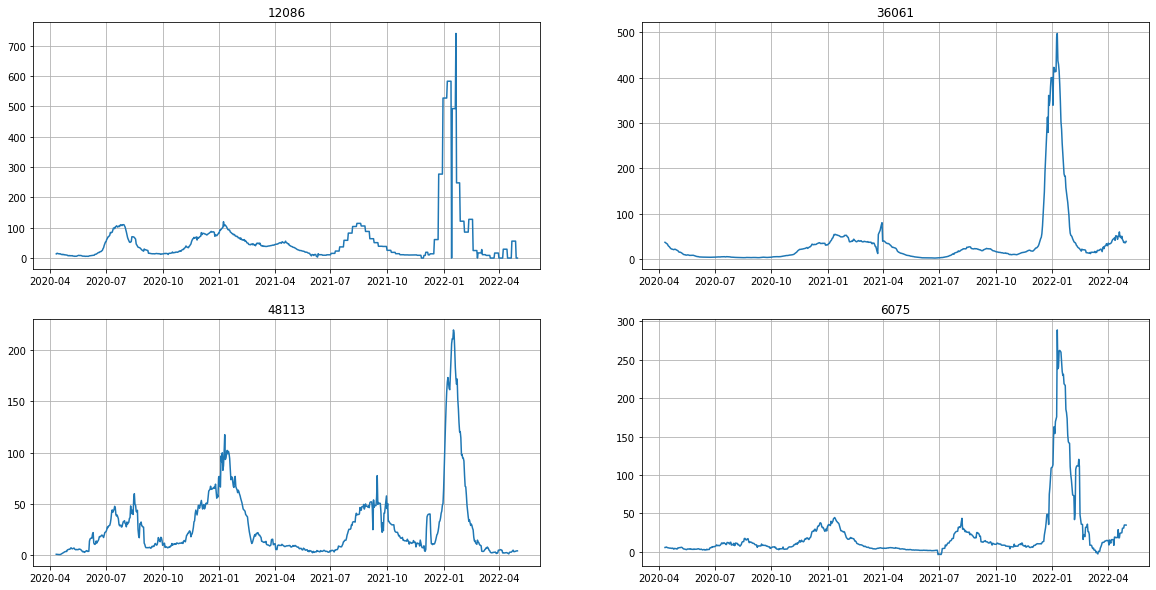

In [3]:
ts.plot()

<h3> Get errors </h3>

In [4]:
transforms = [LagTransform(in_column="target", lags=[7, 14, 21]), LagTransform(in_column="facebook", lags=[7, 14, 21]), DateFlagsTransform(), LinearTrendTransform(in_column="target")]
model = LinearPerSegmentModel()

res_final = get_errors(ts, pd.Timestamp("2021-02-01"), model=model, transforms=transforms).dropna()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 455 out of 455 | elapsed:   42.9s finished
100%|██████████| 455/455 [02:57<00:00,  2.57it/s]

In [7]:
res_final.head()

,segment,timestamp,mape,mae,forecast,mae_lag7
0,36061,2021-02-01,8.893413,4.440432,54.369876,1.382498
1,48113,2021-02-01,17.750313,11.252668,74.646864,2.699009
2,6075,2021-02-01,63.026585,10.971549,28.379361,8.819299
3,12086,2021-02-01,15.329297,10.185493,76.630111,11.339699
4,36061,2021-02-02,13.178224,6.355582,54.583490,0.921665


<h3> Compute optimal betas </h3>

In [8]:
allBetas = computeBetasByGeoByTime(res_final, col2use="mae")

<h3> Parameters </h3>

Hyperparameters

In [9]:
alpha = 0.1
gammaGrid = [0.001, 0.002, 0.004, 0.008, 0.0160, 0.032, 0.064, 0.128]

From paper

In [10]:
I = len(allBetas[0])
alpha_div = (1-alpha) ** 2 * alpha ** 3 + (1-alpha) ** 3 * alpha ** 2
eta = np.sqrt(3 / I) * np.sqrt((np.log(len(gammaGrid) * I) + 2) / alpha_div)

sigma = 1 / (2 * I)

<h3> Get errors and alphas </h3>

In [11]:
allRes = []
for k in range(len(allBetas)):
    allRes.append(conformalAdaptStable(allBetas[k], alpha, gammaGrid, sigma=sigma, eta=eta))

<h3> Plotters </h3>

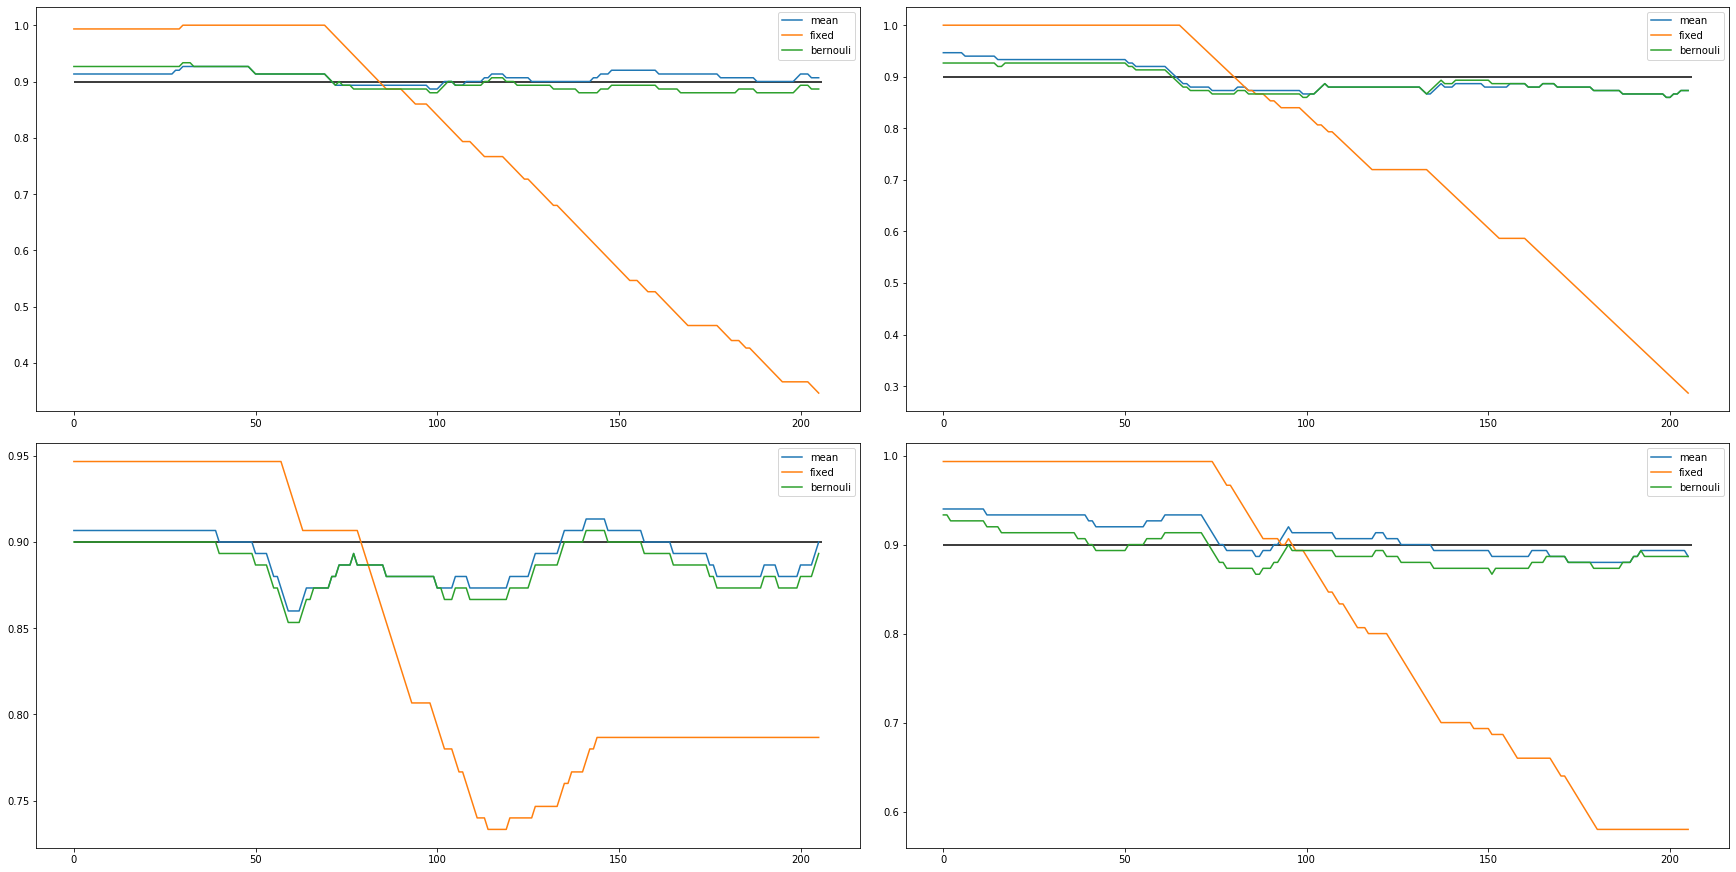

In [13]:
_, ax = prepare_axes(num_plots=4, columns_num=2, figsize=(12, 6))

plot_coverage_level(ax[0], allRes[0][2], allRes[0][5], allRes[0][1])
plot_coverage_level(ax[1], allRes[1][2], allRes[1][5], allRes[1][1])
plot_coverage_level(ax[2], allRes[2][2], allRes[2][5], allRes[2][1])
plot_coverage_level(ax[3], allRes[3][2], allRes[3][5], allRes[3][1])

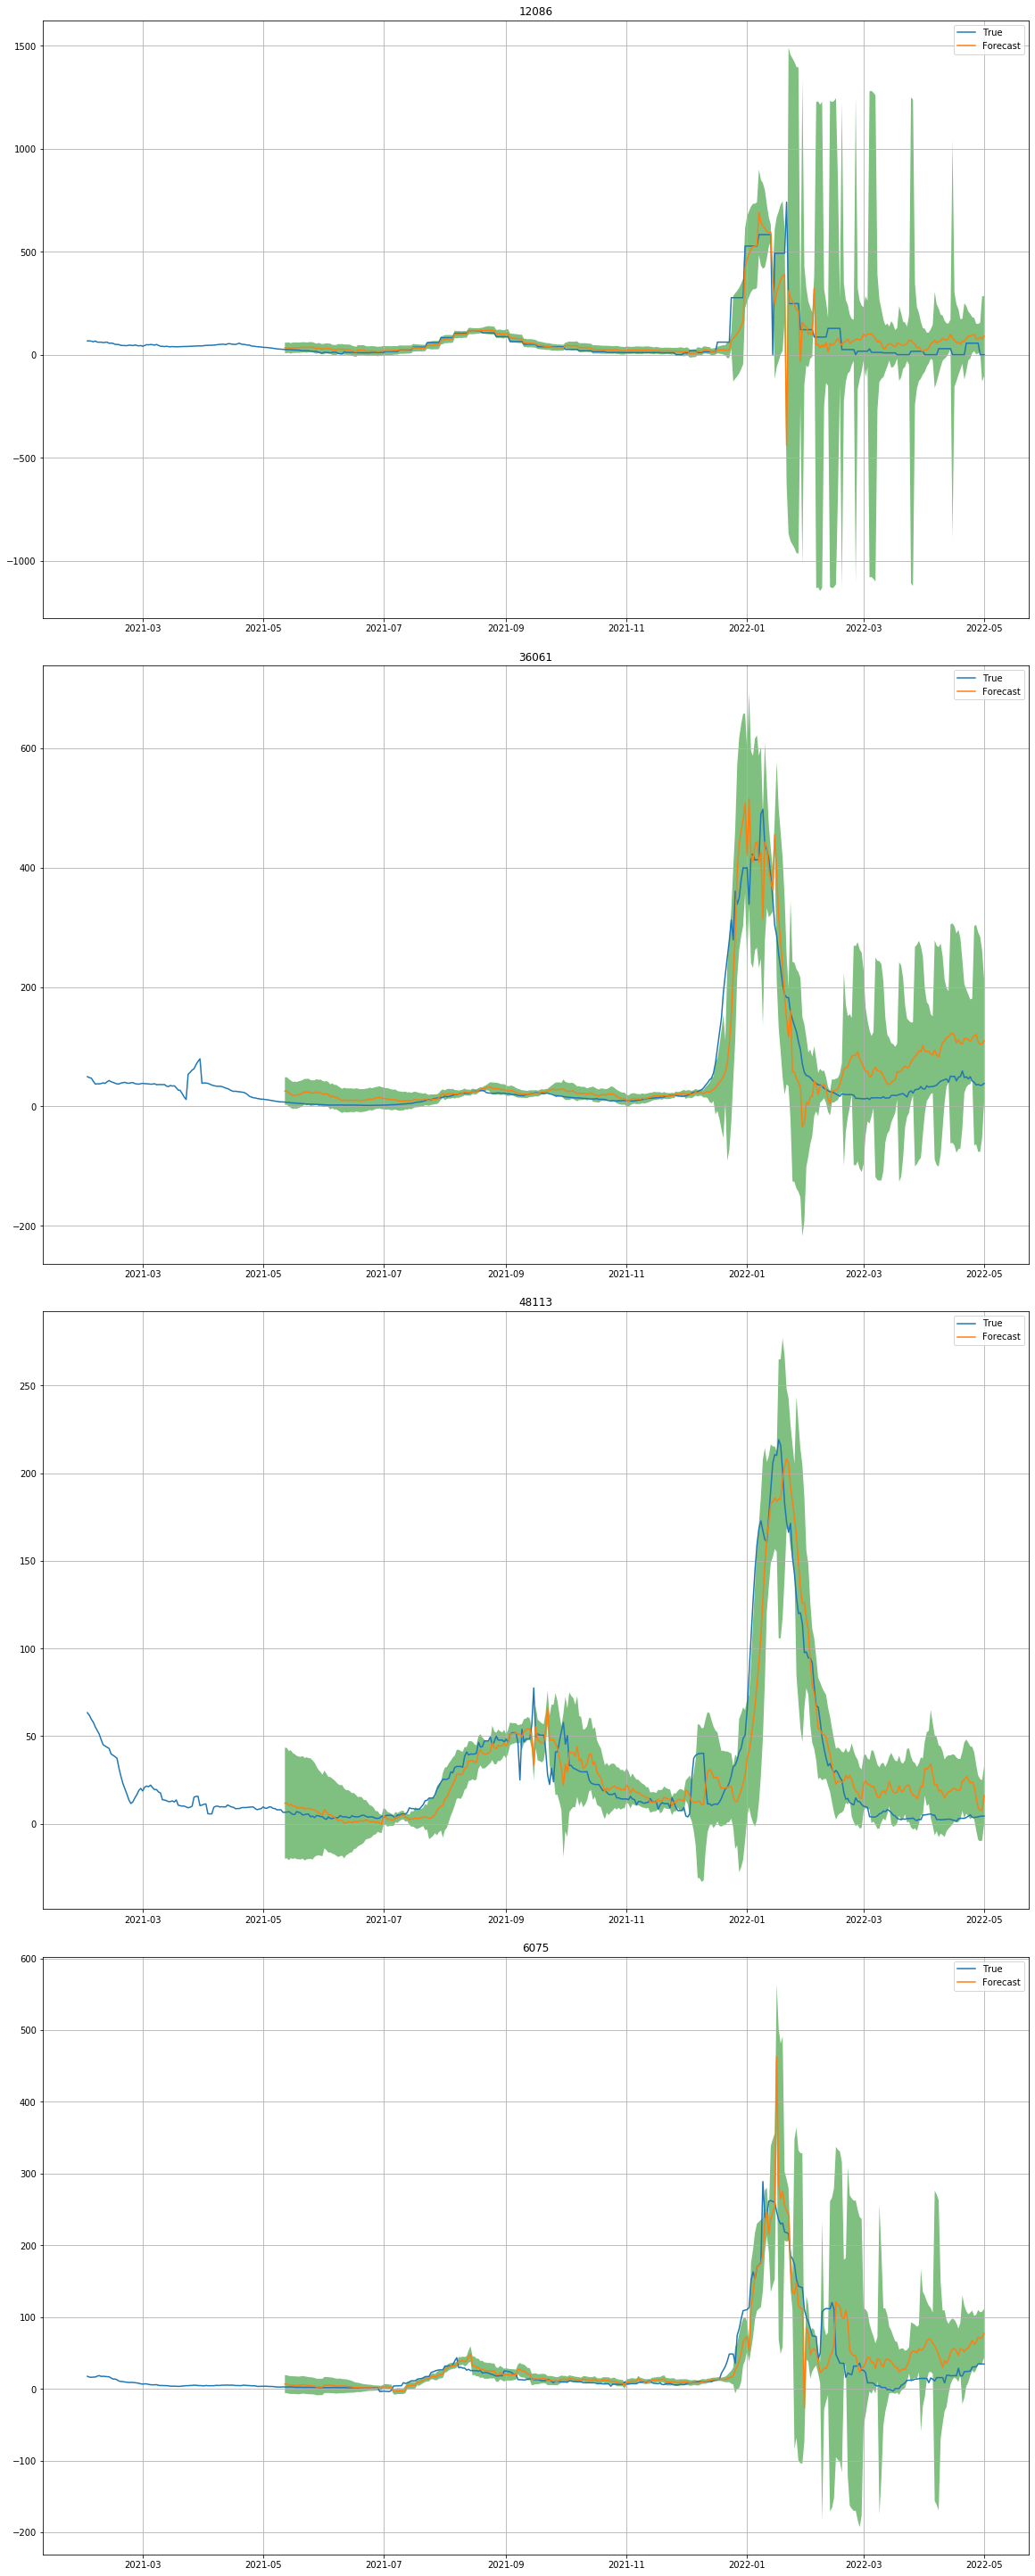

In [14]:
plot_with_intervals(ts, res_final, allRes, col2use="mae")